## Семинар 9: "LSTM"

ФИО: Коновалов Михаил Анатольевич

In [1004]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn import MSELoss
from tqdm.notebook import tqdm
import math
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [1028]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        std = 1 / math.sqrt(self.hidden_size)
        self.W_i = nn.Parameter(nn.init.uniform_(torch.Tensor(input_size, self.gate_size), -std, std))
        
        self.W_h = nn.Parameter(nn.init.uniform_(torch.Tensor(hidden_size, self.gate_size), -std, std))
        
        self.b = nn.Parameter(nn.init.uniform_(torch.Tensor(self.gate_size), -std, std))
#         self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
#         self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
#         self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden=None):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        if hidden:
            h, c = hidden
        else:
            h, c = torch.zeros(self.hidden_size), torch.zeros(self.hidden_size)
        bs = inputs.size(1)
        
        seq_length = inputs.size(0)
        out = torch.Tensor(seq_length, bs, self.hidden_size)
        
        for i, inp in enumerate(inputs):
            S = torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b
            S = S.view(bs, 4, self.hidden_size)
            i_1 = torch.sigmoid(S[:, 0, :])
            f_1 = torch.sigmoid(S[:, 1, :])
            g_1 = torch.tanh(S[:, 2, :])
            o_1 = torch.sigmoid(S[:, 3, :])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

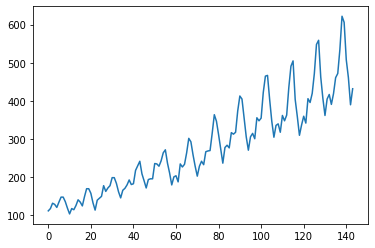

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [965]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [966]:
def prepare_train_test(dataset, look_back, batch_size):
    dataset = dataset.values
    dataset = dataset.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    
    test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_dataset, train_dataloader, test_dataset, test_dataloader

In [967]:
train_dataset, train_dataloader, test_dataset, test_dataloader = prepare_train_test(dataset, 20, 10)

In [1008]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Network, self).__init__()
        
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size)
        self.linear = nn.Linear(hidden_size, 1)
        
        
    def forward(self, inputs):
        lstm_output, (h, c) = self.lstm(inputs)
        linear_output = self.linear(h)
        return linear_output

In [1009]:
def mse_loss(model, dataset):
    X = dataset.tensors[0]
    outs = model(X.permute(2, 0, 1)).squeeze()
    return float(torch.dot((dataset.tensors[1][:, 0] - outs), (dataset.tensors[1][:, 0] - outs)) / len(dataset))


def point_by_point_mse(model, train_dataset, test_dataset=None):
    look_back = train_dataset[:][0].shape[2]
    if test_dataset:
        start = train_dataset[-1][0][0].clone().detach()
        for j in range(look_back - 1):
            start[j] = start[j + 1]
        start[look_back - 1] = float(train_dataset[-1][1])
        
        outputs = []
        for _ in range(test_dataset[:][0].shape[0]):
            output = model(start.reshape(-1, 1, 1))
            outputs.append(float(output))
            for j in range(look_back - 1):
                start[j] = start[j + 1]
            start[look_back - 1] = float(output)
            
        dataset = test_dataset
        
    else:
        start = train_dataset[0][0][0].clone().detach()
        
        outputs = [float(item) for item in start]
        for _ in range(train_dataset[:][0].shape[0] - look_back):
            output = model(start.reshape(-1, 1, 1))
            outputs.append(float(output))
            for j in range(look_back - 1):
                start[j] = start[j + 1]
            start[look_back - 1] = float(output)
        
        dataset = train_dataset
    assert(len(dataset) == len(outputs))

    outputs = torch.Tensor(outputs)
    return float(torch.dot((dataset.tensors[1][:, 0] - outputs), (dataset.tensors[1][:, 0] - outputs)) / len(dataset))

In [1010]:
def make_full_plot(model, dataset):
    X = dataset.tensors[0]
    outs = model(X.permute(2, 0, 1)).squeeze()
    plt.plot(dataset.tensors[1], c="red", label="Data")
    plt.plot(outs.detach(), c="blue", label="Model")
    plt.legend()
    plt.show()
    

def make_point_by_point_plot(model, train_dataset, test_dataset=None):
    look_back = train_dataset[:][0].shape[2]
    if test_dataset:
        start = train_dataset[-1][0][0].clone().detach()
        for j in range(look_back - 1):
            start[j] = start[j + 1]
        start[look_back - 1] = float(train_dataset[-1][1])
        
        outputs = []
        for _ in range(test_dataset[:][0].shape[0]):
            output = model(start.reshape(-1, 1, 1))
            outputs.append(float(output))
            for j in range(look_back - 1):
                start[j] = start[j + 1]
            start[look_back - 1] = float(output)
            
        dataset = test_dataset
        
    else:
        start = train_dataset[0][0][0].clone().detach()
        outputs = [float(item) for item in start]
        for _ in range(train_dataset[:][0].shape[0] - look_back):
            output = model(start.reshape(-1, 1, 1))
            outputs.append(float(output))
            for j in range(look_back - 1):
                start[j] = start[j + 1]
            start[look_back - 1] = float(output)
        
        dataset = train_dataset
    assert(len(dataset) == len(outputs))
    plt.plot(dataset[:][1], c="red", label="Data")
    plt.plot(outputs, c="blue", label="Model")
    plt.legend()
    plt.show()

In [1011]:
def train_model(hidden_size, n_epochs, lr=1e-3):
    loss = nn.MSELoss()
    input_size = 1

    model = Network(input_size, hidden_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for i in tqdm(range(n_epochs), total=n_epochs):
        loss_values = []
        for batch in train_dataloader:
            X = batch[0]
            y = batch[1]

            optimizer.zero_grad()
            output = model(X.permute(2, 0, 1))
            loss_value = loss(output.squeeze(), y.squeeze())
            loss_value.backward()
            optimizer.step()
            loss_values.append(loss_value.data)
        
        if not (i + 1) % 100:
            train_mse = mse_loss(model, train_dataset)
            train_pbp_mse = point_by_point_mse(model, train_dataset)
            test_mse = mse_loss(model, test_dataset)
            test_pbp_mse = point_by_point_mse(model, train_dataset, test_dataset)
            print(f"[{i + 1}]\tTrain: {train_mse}\tTrain_pbp: {train_pbp_mse}\n\tTest:  {test_mse}\tTest_pbp:  {test_pbp_mse}\n")
            
    return model

In [1012]:
look_back = 20
batch_size = 10
train_dataset, train_dataloader, test_dataset, test_dataloader = prepare_train_test(dataset, look_back, batch_size)

придумать, как ввести ее в лосс

попробовать разные режимы обучения: с увеличением батча (от нескольких точек до всего датасета - и построение теста по всему трейну)

In [1034]:
model = train_model(512, 1000, 1e-3)

[100]	Train: 0.0019785789772868156	Train_pbp: 0.0056974561884999275
	Test:  0.05089723691344261	Test_pbp:  0.11078988015651703

[200]	Train: 0.0006769177853129804	Train_pbp: 0.016566818580031395
	Test:  0.0059740422293543816	Test_pbp:  0.041043639183044434

[300]	Train: 0.0005253737326711416	Train_pbp: 0.04939280450344086
	Test:  0.0022948288824409246	Test_pbp:  0.019018152728676796

[400]	Train: 0.0003943141200579703	Train_pbp: 0.02017366513609886
	Test:  0.0021001400891691446	Test_pbp:  0.02951801009476185

[500]	Train: 0.0002980055578518659	Train_pbp: 0.04235231503844261
	Test:  0.0026169365737587214	Test_pbp:  0.02515522576868534

[600]	Train: 0.0001906802353914827	Train_pbp: 0.04492509737610817
	Test:  0.0022118096239864826	Test_pbp:  0.0525200217962265

[700]	Train: 0.000157933754962869	Train_pbp: 0.008568981662392616
	Test:  0.002828227588906884	Test_pbp:  0.04501648619771004

[800]	Train: 0.0008979797130450606	Train_pbp: 0.03862624615430832
	Test:  0.0029036228079348803	Test_pb

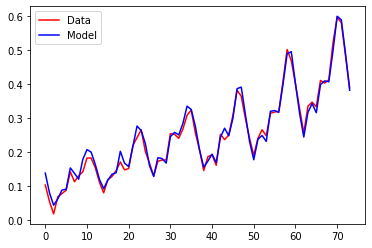

In [1035]:
make_full_plot(model, train_dataset)

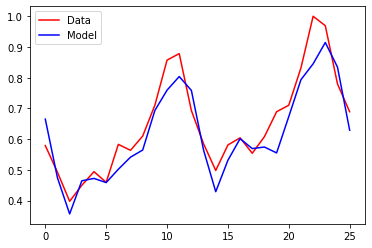

In [1036]:
make_full_plot(model, test_dataset)

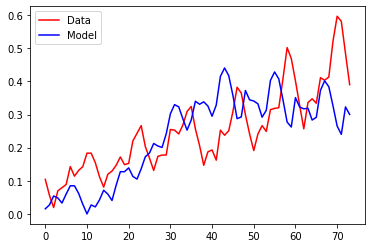

In [1037]:
make_point_by_point_plot(model, train_dataset)

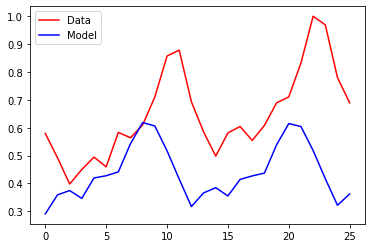

In [1038]:
make_point_by_point_plot(model, train_dataset, test_dataset)

In [1050]:
!ls

Practice task 7, LSTM-Copy1.ipynb    Practice task 9, LSTM.ipynb
Practice task 7, LSTM.ipynb          international-airline-passengers.csv


#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: